In [1623]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [1624]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [1625]:
measurements_used = 2000
time_series_used = 2
# energy_per_time = 1000
generate_graphs = False
show_plots = True

get_timeseries = True
get_measurements = False

In [1626]:
# exp_name = "compiler"
# exp_name = "measuring_instrument"
exp_name = "app"
# exp_name = "run-many-times"
# exp_name = "cores"

In [1627]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

idle_case_config = -1

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

# used_os_names = [
#     windows, 
#     linux
# ]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp, ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [1628]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_os_names = [
        windows, 
        linux
    ]
    
    used_mi_names = [
        ipg, scaphandre, lhm, plug, rapl, clamp, rapl
        # clamp
        # ipg, clamp, plug, lhm, rapl #, lhm, scaphandre, # plug, rapl
        # lhm#, plug
        # lhm #clamp
        # rapl, plug
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]
    
if exp_name == "run-many-times":
    experiment_name = "run-clamp-many-times-exp"
    experiment_number = 2
    
    used_os_names = [
        windows, 
    ]
    
    used_dut_name = [
        'workstationtwo',
    ]
    
    used_test_case_names = [
        'mandelbrot.exe',
    ]
    
    used_mi_names = [
        clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]

if exp_name == 'cores':
    experiment_name = "same-one-api-compiler-different-cores"
    experiment_number = 3
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg #, clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    used_test_case_names = [
        'nbody.exe',
        'spectral-norm.exe',
        # 'idle-case.exe'
    ]
    
    used_thread = [
        'single-threaded'
    ]
    
    used_allocated_cores = [
        ['0'], 
        ['1'], 
        ['2'],
        ['3'],
        ['4'],
        ['5'],
        ['6'],
        ['7'],
        ['8'],
        ['9'],
    ]
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = ["", "180000000", "18000"]

if exp_name == 'app':
    experiment_name = "same-mi-different-application-post-config-update"
    experiment_number = 3
    used_burn_in = 0
    
    used_test_case_name = 'idle.exe'
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg, 
        # clamp
    ]
    
    used_compilers = [
        'unkown'
    ]
    
    used_test_case_names = [
        '3d-mark.exe',
        # 'pc-mark-10.exe',
        # 'idle.exe'
    ]
    
    used_thread = [
        'multi-threaded'
    ]
    
    used_allocated_cores = [
        # # ['4'],
        # ['4', '3'],
        # ['4', '3', '2'],
        # ['4', '3', '2', '1'],
        # ['4', '3', '2', '1', '5'],
        # ['4', '3', '2', '1', '5', '0'],
        # ['4', '3', '2', '1', '5', '0', '8'],
        # ['4', '3', '2', '1', '5', '0', '8', '7'],
        # ['4', '3', '2', '1', '5', '0', '8', '7', '6'],
        ['4', '3', '2', '1', '5', '0', '8', '7', '6', '9'],
        
        # ['0'],
        # ['0', '5'],
        # ['0', '5', '6'],
        # ['0', '5', '6', '2'],
        # ['0', '5', '6', '2', '4'],
        # ['0', '5', '6', '2', '4', '3'],
        # ['0', '5', '6', '2', '4', '3', '1'],
        # ['0', '1', '2', '3', '4', '5', '6', '7'],
    ]
    
    idle_case_config = 2
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = [""]


used_mi_names.sort()
used_compilers.sort()

In [1629]:
used_test_case_names

['3d-mark.exe']

### DUTs

In [1630]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [1631]:
dut = rep.get_devices_under_test(db)
dut.shape

(9, 4)

In [1632]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut.shape

(1, 4)

### Test Cases

In [1633]:
tc = rep.get_test_cases(db)

tc.shape

(36, 8)

In [1634]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [1635]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [1636]:
used_test_case_parameters

''

### Measuring Instruments

In [1637]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [1638]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [1639]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [1640]:
config = rep.get_configurations(db)

config.shape

(32, 5)

In [1641]:
config.shape

(32, 5)

In [1642]:
config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"
3,4,0,200,0,"[0, 1, 2, 3, 4, 5, 6, 7]"
4,5,0,100,0,"[0, 1]"
5,6,0,200,1,[0]
6,7,0,200,1,[1]
7,8,0,200,1,[2]
8,9,0,200,1,[3]
9,10,0,200,1,[4]


In [1643]:
used_allocated_cores_str

"'[4, 3, 2, 1, 5, 0, 8, 7, 6, 9]'"

In [1644]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            # f"{ALLOCATED_CORES} in ('[1]')")
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
                            # f"CAST({ALLOCATED_CORES} as CHAR) = [{used_allocated_cores_str}]")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
18,19,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6, 9]"


### Experiment Names

In [1645]:
exp = rep.get_distinct_experiments(db)

exp.shape

(12, 2)

## Used Things

In [1646]:
used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod


In [1647]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
30,34,3d-mark.exe,unkown,unknown,,application,,multi-threaded


In [1648]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100


In [1649]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
31,35,idle.exe,unkown,unknown,,application,,multi-threaded


In [1650]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
18,19,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6, 9]"


In [1651]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )

begin - 3d-mark.exe.ipg.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.win32nt.100.34
done


In [1652]:
# [x for x in time_series[0]["fannkuch-redux.exe.rapl.workstationone.all.intel-one-api.unix"].iterrows()]

In [1653]:
key = list(time_series.keys())[0]
key

'3d-mark.exe.ipg.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.win32nt'

In [1654]:
# list(time_series['pc-mark-10.exe.ipg.workstationone.[0, 1, 2, 3, 4, 5, 6, 7].unkown.win32nt'][0]['AdditionalMetadata'])[0]##['GpuUtilization']
# power = list(time_series['pc-mark-10.exe.ipg.workstationone.[0, 1, 2, 3, 4, 5, 6, 7].unkown.win32nt'][0]['ProcessorPowerInWatt'])
# time = list(time_series['pc-mark-10.exe.ipg.workstationone.[0, 1, 2, 3, 4, 5, 6, 7].unkown.win32nt'][0]['ElapsedTime'])

power = list(time_series[key][1]['ProcessorPowerInWatt'])
time = list(time_series[key][1]['ElapsedTime'])

In [1655]:
for a,b in zip(time, power):
    # if a > 30:
    #     print(f'({a - 30}, {b})')
    # if a > 30:
    print(f'({a}, {b})')

(0.020000457763671875, 7.98799991607666)
(0.13100051879882812, 7.883999824523926)
(0.24200057983398438, 7.9730000495910645)
(0.3540000915527344, 7.948999881744385)
(0.4650001525878906, 8.01099967956543)
(0.5769996643066406, 7.998000144958496)
(0.6730003356933594, 7.872000217437744)
(0.7849998474121094, 7.914999961853027)
(0.8969993591308594, 7.821000099182129)
(1.0090007781982422, 7.964000225067139)
(1.1200008392333984, 7.869999885559082)
(1.2320003509521484, 7.9019999504089355)
(1.3439998626708984, 7.979000091552734)
(1.4549999237060547, 7.828000068664551)
(1.5669994354248047, 7.985000133514404)
(1.6770000457763672, 7.804999828338623)
(1.7889995574951172, 7.874000072479248)
(1.8999996185302734, 7.889999866485596)
(2.0120010375976562, 7.974999904632568)
(2.1230010986328125, 7.8429999351501465)
(2.2350006103515625, 7.985000133514404)
(2.3479995727539062, 7.961999893188477)
(2.4599990844726562, 7.806000232696533)
(2.5680007934570312, 8.017000198364258)
(2.6800003051757812, 7.802000045776

3d-mark.exe.ipg.workstationtwo.[4, 3, 2, 1, 5, 0, 8, 7, 6, 9].unkown.win32nt


<Figure size 640x480 with 0 Axes>

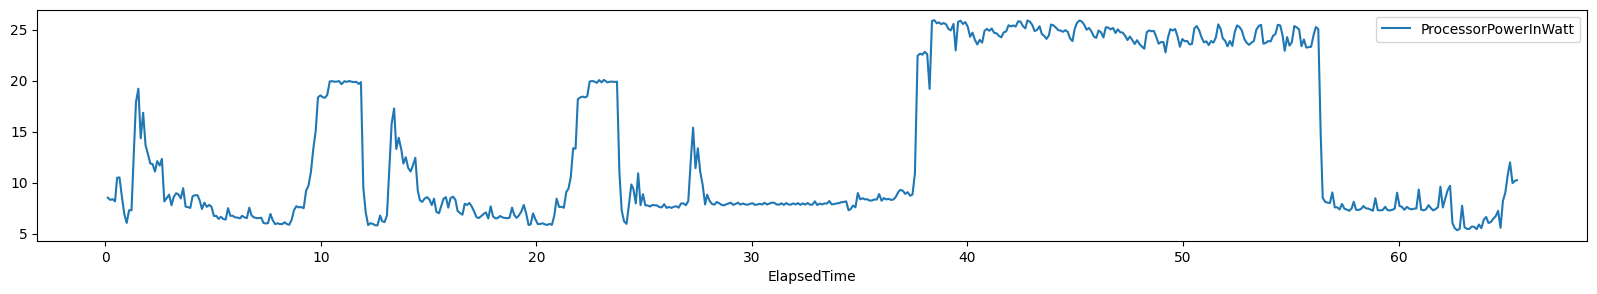

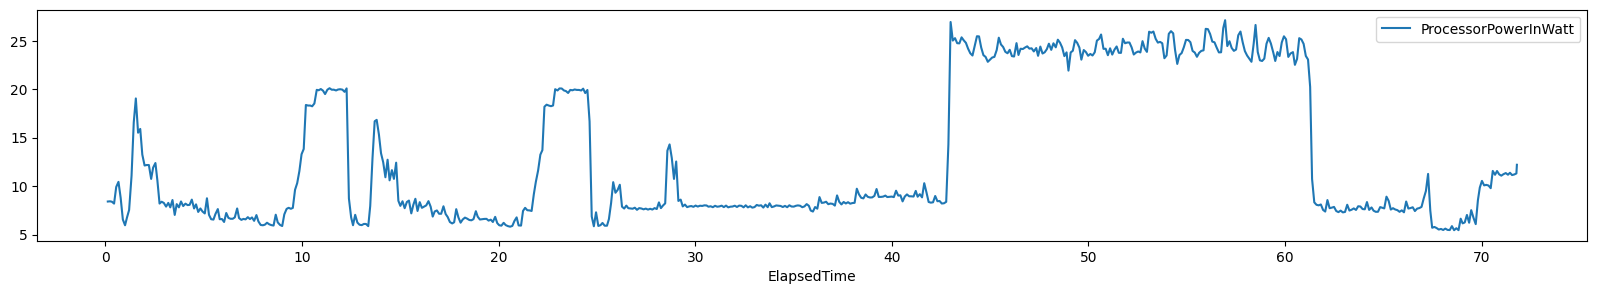

In [1656]:
for key in time_series.keys():
    print(key)
    for table in time_series[key]:
        if "clamp" in key or "plug" in key or "scaphandre" in key or 'lhm' in key:
            table.plot(x="ElapsedTime", y="CpuEnergyInJoules")
        if "ipg" in key:
            table.plot(x="ElapsedTime", y="ProcessorPowerInWatt", figsize=(20,3))
        if "rapl" in key:
            table['rapl_column'] = df_util.get_rapl_column(table, "total_core")
            table.plot(x="ElapsedTime", y="rapl_column")
        plot.show()

In [1657]:
used_configs.shape, used_dut.shape, used_mi.shape, used_tc.shape, used_idle_case.shape


((1, 5), (1, 4), (1, 3), (1, 8), (1, 8))

In [1658]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
18,19,0,200,0,"[4, 3, 2, 1, 5, 0, 8, 7, 6, 9]"


In [1659]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
31,35,idle.exe,unkown,unknown,,application,,multi-threaded


In [1660]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
30,34,3d-mark.exe,unkown,unknown,,application,,multi-threaded


In [1661]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
30,34,3d-mark.exe,unkown,unknown,,application,,multi-threaded


In [1662]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_watt_consumption = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption,
        idle_case_config = idle_case_config
    )

In [1663]:
if get_measurements:
    df_util.trim_dataframes(
        measurements_used,
        dram_energy_results,
        cpu_energy_results,
        gpu_energy_results,
        duration_results,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        temperature_end,
        temperature_begin,
        cpu_dynamic_energy_watt_consumption
    )

In [1664]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [1665]:
if get_measurements:
    ## Energy consumption for the entire test case
    dram_energy_results = convert_to_series(dram_energy_results)
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_energy_results = convert_to_series(cpu_energy_results)
    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_energy_results = convert_to_series(gpu_energy_results)
    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_results = convert_to_series(duration_results)
    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_energy_consumption = convert_to_series(dram_dynamic_energy_consumption)
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_energy_consumption = convert_to_series(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))
    
    cpu_dynamic_energy_watt_consumption = convert_to_series(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = pd.DataFrame(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = cpu_dynamic_watt_df.reindex(columns=sorted(cpu_dynamic_watt_df.columns))

    gpu_dynamic_energy_consumption = convert_to_series(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_consumption_results = convert_to_series(idle_cpu_consumption_results)
    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin = convert_to_series(temperature_begin)
    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end = convert_to_series(temperature_end)
    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))




In [1666]:
if get_measurements:
    for column in duration_df.columns:
        duration_df[column] = duration_df[column] / 1000

In [1667]:
if get_measurements and show_plots:
    test_boxplot = dram_df.boxplot(figsize=(15,1), rot=75, column=[dram_df.columns[0]])
    test_boxplot.plot()
    plot.ylim(0, 40)
    plot.show()
    
    
    # print("Combined DRAM Energy Consumption in Joules")
    # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=85)
    # # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75, column=['fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt'])
    # dram_boxplot.plot()
    # plot.ylim(0, 40)
    # plot.show()

    print("Combined CPU Energy Consumption in Joules")
    cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=85)
    cpu_boxplot.plot()
    cpu_boxplot
    plot.ylim(0,max(list(cpu_df.max())) + 200)
    plot.show()

    # print("Combined GPU Energy Consumption in Joules")
    # gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=85)
    # gpu_boxplot.plot()
    # plot.ylim(0,50)
    # plot.show()

    print("Duration of Test Case")
    duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=85)
    duration_boxplot.plot()
    # plot.ylim(60,80)
    plot.show()

In [1668]:
cpu_dynamic_watt_df.shape


(20, 9)

In [1669]:
cpu_dynamic_df

,"pc-mark-10.exe.win32nt.workstationone.[0, 1, 2, 3, 4, 5, 6, 7].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2, 4, 3, 1].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2, 4, 3].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2, 4].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5].unkown.ipg",pc-mark-10.exe.win32nt.workstationone.[0].unkown.ipg
0,11688.476887,11802.150896,11771.678239,11775.641092,11898.574003,12129.969135,12464.750349,14150.528583
1,11837.411866,11922.294132,11833.279458,11853.251894,11926.082314,12072.226279,12571.445824,14105.796406
2,11781.799086,11876.171499,11847.416843,11909.692913,11989.152991,12157.693786,12514.791466,14050.364322
3,11803.770527,11867.076962,11863.344807,11949.648263,12074.480021,12180.768789,12596.938909,14115.606357
4,11810.219410,12054.718625,11913.079031,11854.482676,12040.432817,12235.102769,12617.282518,14166.630316
5,11894.213428,12116.763793,12059.096657,11997.661703,12098.621095,12400.668485,12593.327253,14182.585961
6,11818.705193,11932.544278,11917.478985,12045.604030,12150.410080,12260.627400,12803.129774,14397.399564
7,11917.649131,12072.216046,12056.613032,12063.693813,12079.251369,12272.468849,12686.900811,14450.263143
8,11901.655291,12152.637545,12105.910045,12003.209184,12203.810957,12382.551529,12642.352168,14353.220194
9,12103.205808,12368.270152,12264.967584,12146.320132,12303.453832,12509.677837,12877.209305,14401.398791


In [1670]:
if get_measurements and show_plots:
    # print("Dynamic DRAM Energy Consumption in Watts")
    # dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_dram_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()

    print("Dynamic CPU Energy Consumption in Joiles")
    dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=85)
    dynamic_cpu_boxplot.plot()
    # plot.ylim(-100, 100)
    plot.show()
    
    print("Dynamic CPU Energy Consumption in Watts")
    dynamic_watt_cpu_boxplot = cpu_dynamic_watt_df.boxplot(figsize=(15,5), rot=85)
    dynamic_watt_cpu_boxplot.plot()
    plot.ylim(0,50)
    plot.show()
    
    

    # print("Dynamic GPU Energy Consumption in Watts")
    # dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_gpu_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()


In [1671]:
def list_to_label(lst, mapper):
    if len(lst) == 1:
        return mapper[lst[0]]
    elif len(lst) == 2:
        return f"{mapper[lst[0]]} and {mapper[lst[1]]}"
    else:
        return ", ".join([mapper[x] for x in lst[:-1]]) + f" and {mapper[lst[-1]]}"

def get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler):
    caption = f"{name} measurements"

    if not ',' in c_measuring_instrument:
        caption += f" by {c_measuring_instrument}"

    if not ',' in c_duts:
        caption += f" on {c_duts}"
        
    if not ',' in c_test_cases:
        caption += f" for test case(s) {c_test_cases}"
        
    if not ',' in c_compiler:
        caption += f" compiled on {c_compiler}"

    return caption

In [1672]:
dut_name_mapper = {
    "workstationone" : "DUT 1",
    "workstationtwo" : "DUT 2"
}

compiler_mapper = {
    "clang" : "Clang",
    "min-gw" : "MinGW",
    "intel-one-api" : "oneAPI",
    "msvc" : "MSVC",
    "unkown" : ""
}

test_case_mapper = {
    "fannkuch-redux.exe" : "FR",
    "3d-mark.exe" : "3DM",
    "pc-mark-10.exe" : "PCM",
    "mandelbrot.exe" : "MB",
    "nbody.exe" : "NB",
    "spectral-norm.exe" : "SN"
}

mi_mapper = {
    "ipg" : "IPG",
    "lhm" : "LHM",
    "clamp" : "Clamp",
    "plug" : "Plug",
    "scaphandre" : "SCAP",
    "scaphandre_isolated" : "SCAPI",
    "rapl" : "RAPL"
}

os_mapper = {
    "unix" : 'LIN',
    "win32nt" : "WIN"
}

In [1673]:
box_plot_raw_data = [
    {
        "data" : cpu_df,
        "name" : "CPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "Average Energy Consumption (Joules)"
    },
    {
        "data" : cpu_dynamic_df,
        "name" : "CPU",
        "data_type" : "DEC",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 1000,
        "xlabel" : "Average DEC (Joules)"
    },
    {
        "data" : cpu_dynamic_watt_df,
        "name" : "CPU",
        "data_type" : "DEC per second",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "Average DEC (Watts)"
    },
    # {
    #     "data" : dram_dynamic_df,
    #     "name" : "DRAM",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : dram_df,
    #     "name" : "DRAM",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 40,
    #     "xlabel" : "Total Energy Consumption (Joules)"
    # },
    # {
    #     "data" : gpu_dynamic_df,
    #     "name" : "GPU",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : gpu_df,
    #     "name" : "GPU",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 50,
    #     "xlabel" : "Total Energy Consumption (Watt)"
    # },
    {
        "data" : duration_df,
        "name" : "Runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Average Runtime (s)"
    }
]

In [1674]:
if generate_graphs and get_measurements:
    for plot_data in box_plot_raw_data:
        print("start")
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        plot.clf()
        # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
        
        if name == 'Runtime':
            title = f"The average duration"
        else:
            title = f"The {data_type} of the {name}"
        
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(
            data, 
            used_test_case_names, 
            used_mi_names, 
            used_dut_name, 
            used_allocated_cores, 
            used_compiler_str, 
            used_os_names,
            dut_name_mapper,
            compiler_mapper,
            test_case_mapper,
            mi_mapper,
            os_mapper
            )
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}".lower()
        
        c_test_cases = list_to_label(used_test_case_names, test_case_mapper)
        c_compiler = list_to_label(used_compilers, compiler_mapper)
        c_duts = list_to_label(used_dut_name, dut_name_mapper)
        c_measuring_instrument = list_to_label(used_mi_names, mi_mapper)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler)
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        # print(data)
        path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating plots is disabled


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [1675]:
# \addplot[mark=none, blue] coordinates {(1000,0) (1000,5)};

In [1676]:
def remove_n_percent(df, column, percent):
    data_to_order = df[column]

    list(data_to_order).sort()
    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    percent = 20

    n = len(data_to_order)
    outliers = int(n*percent/100) #may want some rounding logic if n is small
    trimmed_data = data_to_order[outliers: n-outliers]
    
    return trimmed_data

def remove_n_first(df, column, n):
    data_to_order = df[column]

    data_to_order = [x for x in data_to_order if str(x) != 'nan']
    data_to_order
    trimmed_data = data_to_order[n:]
    
    return trimmed_data

In [1677]:
# percent = 20
# n = len(used_df['spectral-norm.exe.win32nt.workstationtwo.[2].intel-one-api.ipg'])
# outliers = n*percent/100 #may want some rounding logic if n is small
# trimmed_data = sorted_data[outliers: n-outliers]

In [1678]:
def  remove_outliers_z_score(df, column, limit):
    df['z_score'] = np.abs((df[column] - df[column].mean()) / df[column].std())

    # identify outliers as data points with z-score > 3
    outliers = df[column][df['z_score'] > limit]
    
    return [
        x for x in list(df[column]) if x not in list(outliers)
    ]

In [1679]:
used_df

,"pc-mark-10.exe.win32nt.workstationone.[0, 1, 2, 3, 4, 5, 6, 7].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2, 4, 3, 1].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2, 4, 3].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2, 4].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6, 2].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5, 6].unkown.ipg","pc-mark-10.exe.win32nt.workstationone.[0, 5].unkown.ipg",pc-mark-10.exe.win32nt.workstationone.[0].unkown.ipg,z_score
0,7.271479,7.248827,7.257779,7.113847,6.819296,6.733113,6.212079,4.844074,0.037093
1,7.488357,7.421963,7.346813,7.225086,6.857692,6.654364,6.349637,4.797104,0.254802
2,7.407374,7.355497,7.367247,7.305983,6.945725,6.770923,6.276595,4.738899,0.524587
3,7.439368,7.342391,7.390268,7.363250,7.064823,6.802392,6.382504,4.807405,0.207058
4,7.448759,7.612797,7.462150,7.226850,7.017301,6.876492,6.408732,4.860981,0.041273
5,7.571070,7.702209,7.673195,7.432068,7.098519,7.102286,6.377847,4.877735,0.118928
6,7.461116,7.436734,7.468510,7.500783,7.170806,6.911301,6.648336,5.103294,1.164414
7,7.605197,7.638012,7.669605,7.526711,7.071483,6.927451,6.498487,5.158802,1.421698
8,7.581907,7.753906,7.740855,7.440019,7.245342,7.077579,6.441053,5.056905,0.949395
9,7.875402,8.064649,7.970747,7.645139,7.384422,7.250951,6.743843,5.107494,1.183878


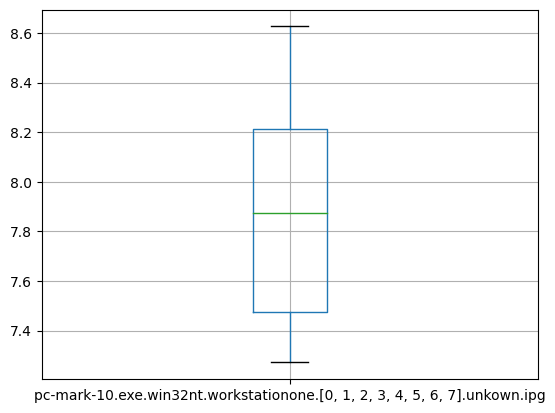

In [1680]:
used_df.boxplot(column='pc-mark-10.exe.win32nt.workstationone.[0, 1, 2, 3, 4, 5, 6, 7].unkown.ipg')
plot.show()
# used_df.boxplot()

In [1681]:
cochrans_data = {
    "" : ["with", "without", 'z', "percent", "count"]
}

plot.clf()

if get_measurements:
    Z = 1.96
    E = 0.03

    # Z = 2.58
    # E = 0.01

    include_outliers = False

    used_df = cpu_dynamic_watt_df

    for column in used_df.columns:
        used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
        used_df_without_n_percent = remove_n_percent(used_df, column, 20)
        used_df_without_z_score_outliers = remove_outliers_z_score(used_df, column, 1.5)
        
        
        
        
        # used_df_remove_n = remove_n_first(used_df, column, 1000)
        # pd_removed = pd.DataFrame({column : used_df_remove_n})
        # used_df_remove_n = math_util.exclude_outliers(pd_removed, column)
        
        
        current_count = used_df[column].count()
        
        values = used_df_without_outlisers
        n_zero_without = math_util.get_cochran(values, Z, E)
        
        values = used_df_without_z_score_outliers
        n_zero_without_z_outliers = math_util.get_cochran(values, Z, E)
        
        # values = used_df_remove_n
        # n_zero_removed = math_util.get_cochran(values, Z, E)
        # print(n_zero_removed)
        
        values = used_df_without_n_percent
        n_zero_percent = math_util.get_cochran(values, Z, E)
        
        values = list(used_df[column])
        n_zero = math_util.get_cochran(values, Z, E)
        
        cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1), round(n_zero_without_z_outliers, 1), round(n_zero_percent, 1), current_count]

pd.DataFrame(cochrans_data).T

,0,1,2,3,4
,with,without,z,percent,count


In [1682]:
# clamp_mandelbrot = [x for x in used_df['mandelbrot.exe.win32nt.workstationone.all.intel-one-api.clamp'] if not str(x) == 'nan']
# clamp_fann = [x for x in used_df['fannkuch-redux.exe.win32nt.workstationone.all.intel-one-api.clamp'] if not str(x) == 'nan']

In [1683]:
# clamp_mandelbrot_mean = sum(clamp_mandelbrot) / len(clamp_mandelbrot)
# clamp_fann_mean = sum(clamp_fann) / len(clamp_fann)

# clamp_mandelbrot_mean, clamp_fann_mean

In [1684]:
# clamp_mandelbrot_std = sum([(x - clamp_mandelbrot_mean) ** 2 for x in clamp_mandelbrot]) / len(clamp_mandelbrot)
# clamp_fann_std = sum([(x - clamp_fann_mean) ** 2 for x in clamp_fann]) / len(clamp_fann)

# clamp_mandelbrot_std, clamp_fann_std

In [1685]:
# clamp_mandelbrot_standard_error = clamp_mandelbrot_std / len(clamp_mandelbrot)
# clamp_fann_standard_error = clamp_fann_std / len(clamp_fann)

# clamp_mandelbrot_standard_error, clamp_fann_standard_error

In [1686]:
# margin_of_error = 0.03
# confidence_level = 0.95

In [1687]:
# clamp_mandelbrot_confidence_level_upper = clamp_mandelbrot_mean + confidence_level * (clamp_mandelbrot_std / len(clamp_mandelbrot))
# clamp_mandelbrot_confidence_level_lower = clamp_mandelbrot_mean - confidence_level * (clamp_mandelbrot_std / len(clamp_mandelbrot))
# clamp_fann_confidence_level_upper = clamp_fann_mean + confidence_level * (clamp_fann_std / len(clamp_fann))
# clamp_fann_confidence_level_lower = clamp_fann_mean - confidence_level * (clamp_fann_std / len(clamp_fann))

In [1688]:
# clamp_mandelbrot_confidence_level_lower, clamp_mandelbrot_confidence_level_upper

In [1689]:
# clamp_fann_confidence_level_lower, clamp_fann_confidence_level_upper

In [1690]:
# margin_of_error * (len(clamp_mandelbrot) / clamp_mandelbrot_std), margin_of_error * (len(clamp_fann) / clamp_fann_std)

In [1691]:
# clamp_mandelbrot_std

In [1692]:
# Z = 1.15988
# E = 0.03

# column = 'mandelbrot.exe.win32nt.workstationone.all.intel-one-api.clamp'

# used_df_without_outlisers = math_util.exclude_outliers(cpu_dynamic_watt_df, column)
# values = used_df_without_outlisers
# n_zero_without = math_util.get_cochran(values, Z, E)

# round(n_zero_without, 1)